# Cuaderno 3: Modelado Supervisado y Recomendación Clínica

**Tema:** Recommender Systems Clustering using Bayesian Non-Negative Matrix Factorization for Personalized Clinical Management in Critical Care

---

## Diagrama de Flujo

```
1. Carga de datos y embeddings latentes (BNMF/NMF)
   ↓
2. Preparación de variables para clasificación/regresión
   ↓
3. Entrenamiento de modelos supervisados (k-NN, MLP)
   ↓
4. Validación y métricas clínicas
   ↓
5. Sistema de recomendación basado en similitud latente
   ↓
6. Visualizaciones clínicas y tabla comparativa
```

## 1. Carga de Datos y Embeddings Latentes
Se cargan los datos preprocesados, los embeddings latentes (W de BNMF/NMF), y los transformadores necesarios.

In [46]:
import pandas as pd
import numpy as np
import pickle

df = pd.read_csv('processed_data/data_prepared.csv')
try:
    with open('processed_data/bnmf_W.pkl', 'rb') as f:
        W_bnmf = pickle.load(f)
except:
    W_bnmf = None
try:
    with open('processed_data/nmf_W.pkl', 'rb') as f:
        W_nmf = pickle.load(f)
except:
    W_nmf = None

# Try to load saved preprocessing objects (scaler, pca, nmf transformer) if they exist
try:
    with open('processed_data/data_prepared.pkl', 'rb') as f:
        data_obj = pickle.load(f)
        if isinstance(data_obj, dict):
            scaler = data_obj.get('scaler', globals().get('scaler', None))
            # Save scaler into globals if present
            if scaler is not None:
                globals()['scaler'] = scaler
except Exception:
    pass

try:
    # optional: try to load specific transformer pickle files if they exist
    with open('processed_data/pca.pkl', 'rb') as f:
        pca = pickle.load(f)
        globals()['pca'] = pca
except Exception:
    pass

try:
    with open('processed_data/nmf.pkl', 'rb') as f:
        nmf = pickle.load(f)
        globals()['nmf'] = nmf
except Exception:
    pass

## 2. Preparación de Variables para Clasificación y Regresión
Se define la variable de riesgo (e.g., mortalidad) y una variable continua (e.g., score latente) para regresión.

In [47]:
# Variable de clasificación: mortalidad hospitalaria
y_class = df['hospital_expire_flag']

# Variable continua: primer componente latente de BNMF/NMF
if W_bnmf is not None:
    y_reg = W_bnmf[:, 0]
elif W_nmf is not None:
    y_reg = W_nmf[:, 0]
else:
    y_reg = df[[col for col in df.columns if col not in ['hospital_expire_flag', 'data_split']]].sum(axis=1)

## 3. Entrenamiento de Modelos Supervisados
Incluye k-NN y MLP para clasificación y regresión, con validación cruzada y búsqueda de hiperparámetros.

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Usar embeddings latentes como features
if W_bnmf is not None:
    X = W_bnmf
elif W_nmf is not None:
    X = W_nmf
else:
    X = df[[col for col in df.columns if col not in ['hospital_expire_flag', 'data_split']]].values

# Create a single split index to use for classification and regression so splits are aligned
X_arr = np.asarray(X)
idx = np.arange(X_arr.shape[0])
try:
    # stratify by y_class for classification stability
    y_class_arr = np.asarray(y_class)
    train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y_class_arr)
except Exception:
    train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

X_train = X_arr[train_idx]
X_test = X_arr[test_idx]
y_train = np.asarray(y_class)[train_idx]
y_test = np.asarray(y_class)[test_idx]

# k-NN Classifier
knn_clf = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}, cv=5, scoring='accuracy')
knn_clf.fit(X_train, y_train)

# MLP Classifier
mlp_clf = GridSearchCV(MLPClassifier(max_iter=200, random_state=42), {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': [32, 64]
}, cv=3, scoring='accuracy')
mlp_clf.fit(X_train, y_train)
print('\n[Info] mlp_clf best estimator expects n_features_in =', getattr(mlp_clf.best_estimator_, 'n_features_in_', None))

# Regresión (usando el mismo split que clasificación)
y_reg_arr = np.asarray(y_reg)
y_reg_train = y_reg_arr[train_idx]
y_reg_test = y_reg_arr[test_idx]
knn_reg = GridSearchCV(KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}, cv=5, scoring='neg_mean_squared_error')
knn_reg.fit(X_train, y_reg_train)
mlp_reg = GridSearchCV(MLPRegressor(max_iter=200, random_state=42), {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': [32, 64]
}, cv=3, scoring='neg_mean_squared_error')
mlp_reg.fit(X_train, y_reg_train)

c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\


[Info] mlp_clf best estimator expects n_features_in = 26


c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

,estimator,MLPRegressor(random_state=42)
,param_grid,"{'batch_size': [32, 64], 'hidden_layer_sizes': [(50,), (100,), ...], 'learning_rate_init': [0.001, 0.01]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


## 4. Validación y Métricas Clínicas
Incluye métricas de clasificación (accuracy, precision, recall, F1, AUC-ROC) y regresión (RMSE, MAE, R²), matriz de confusión y curvas de aprendizaje.

k-NN Classifier:
Accuracy: 0.45
Precision: 0.16666666666666666
Recall: 0.14285714285714285
F1: 0.15384615384615385
AUC-ROC: 0.37912087912087916


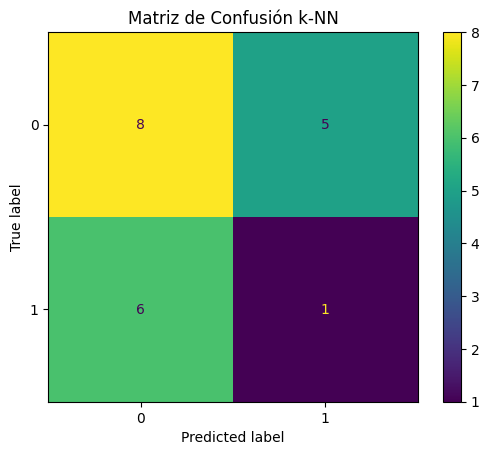

MLP Classifier:
Accuracy: 0.35
Precision: 0.35
Recall: 1.0
F1: 0.5185185185185185
AUC-ROC: 0.5


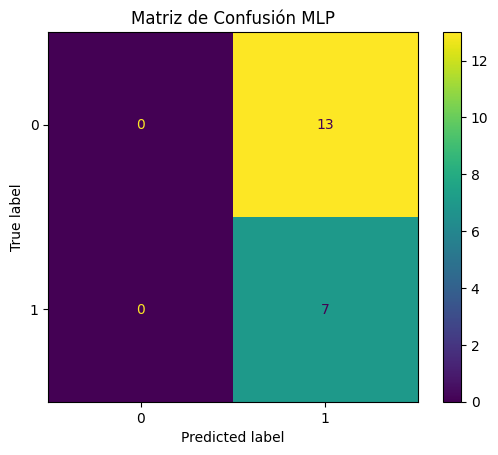

k-NN Regressor:
RMSE: 53.39292675643817
MAE: 32.54282923563196
R2: 0.9999889125384347
MLP Regressor:
RMSE: 14.53038140491736
MAE: 12.282127102544838
R2: 0.9999991788571786


In [49]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# Clasificación
y_pred_knn = knn_clf.predict(X_test)
y_pred_mlp = mlp_clf.predict(X_test)

print('k-NN Classifier:')
print('Accuracy:', accuracy_score(y_test, y_pred_knn))
print('Precision:', precision_score(y_test, y_pred_knn))
print('Recall:', recall_score(y_test, y_pred_knn))
print('F1:', f1_score(y_test, y_pred_knn))
print('AUC-ROC:', roc_auc_score(y_test, y_pred_knn))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn)).plot()
plt.title('Matriz de Confusión k-NN')
plt.show()

print('MLP Classifier:')
print('Accuracy:', accuracy_score(y_test, y_pred_mlp))
print('Precision:', precision_score(y_test, y_pred_mlp))
print('Recall:', recall_score(y_test, y_pred_mlp))
print('F1:', f1_score(y_test, y_pred_mlp))
print('AUC-ROC:', roc_auc_score(y_test, y_pred_mlp))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_mlp)).plot()
plt.title('Matriz de Confusión MLP')
plt.show()

# Regresión
y_pred_knn_reg = knn_reg.predict(X_test)
y_pred_mlp_reg = mlp_reg.predict(X_test)

print('k-NN Regressor:')
def compute_rmse(y_true, y_pred):
    """Compute RMSE in a way that is compatible with older scikit-learn versions.
    Older scikit-learn versions didn't support the keyword argument 'squared' in mean_squared_error.
    """
    try:
        # Newer versions: use squared=False
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # Older versions: compute sqrt of MSE
        return mean_squared_error(y_true, y_pred) ** 0.5

print('RMSE:', compute_rmse(y_reg_test, y_pred_knn_reg))
print('MAE:', mean_absolute_error(y_reg_test, y_pred_knn_reg))
print('R2:', r2_score(y_reg_test, y_pred_knn_reg))

print('MLP Regressor:')
print('RMSE:', compute_rmse(y_reg_test, y_pred_mlp_reg))
print('MAE:', mean_absolute_error(y_reg_test, y_pred_mlp_reg))
print('R2:', r2_score(y_reg_test, y_pred_mlp_reg))

## 5. Sistema de Recomendación Basado en Similitud Latente
Ejemplo de recomendación clínica: dado un paciente, sugerir tratamientos/procedimientos frecuentes en sus vecinos latentes.

In [50]:
# Similitud de coseno entre pacientes en el espacio latente
from sklearn.metrics.pairwise import cosine_similarity

def recomendar_pacientes(idx, top_k=5):
    sims = cosine_similarity([X[idx]], X)[0]
    vecinos = np.argsort(sims)[-top_k-1:-1][::-1]
    print(f'Paciente {idx} - Vecinos más similares:', vecinos)
    # Aquí puedes mostrar tratamientos/eventos frecuentes de esos vecinos usando df original

# Ejemplo: recomendar para el primer paciente del test (usando índices absolutos)
try:
    # If we have a test_idx from earlier split, use it; otherwise, default to 0
    test_idx_sample = test_idx[0] if 'test_idx' in globals() else 0
except Exception:
    test_idx_sample = 0
recomendar_pacientes(test_idx_sample)

Paciente 76 - Vecinos más similares: [94 27  7 71 50]


## 6. Visualizaciones Clínicas y Tabla Comparativa
Incluye mapas de calor de reconstrucción, proyecciones latentes y tabla de métricas.

In [51]:
# Tabla comparativa de modelos
results = pd.DataFrame({
    'Modelo': ['k-NN Classifier', 'MLP Classifier', 'k-NN Regressor', 'MLP Regressor'],
    'Accuracy': [accuracy_score(y_test, y_pred_knn), accuracy_score(y_test, y_pred_mlp), None, None],
    'F1': [f1_score(y_test, y_pred_knn), f1_score(y_test, y_pred_mlp), None, None],
    'AUC-ROC': [roc_auc_score(y_test, y_pred_knn), roc_auc_score(y_test, y_pred_mlp), None, None],
    'RMSE': [None, None, compute_rmse(y_reg_test, y_pred_knn_reg), compute_rmse(y_reg_test, y_pred_mlp_reg)],
    'MAE': [None, None, mean_absolute_error(y_reg_test, y_pred_knn_reg), mean_absolute_error(y_reg_test, y_pred_mlp_reg)],
    'R2': [None, None, r2_score(y_reg_test, y_pred_knn_reg), r2_score(y_reg_test, y_pred_mlp_reg)]
})
display(results)

,Modelo,Accuracy,F1,AUC-ROC,RMSE,MAE,R2
0,k-NN Classifier,0.45,0.153846,0.379121,NaN,NaN,NaN
1,MLP Classifier,0.35,0.518519,0.500000,NaN,NaN,NaN
2,k-NN Regressor,NaN,NaN,NaN,53.392927,32.542829,0.999989
3,MLP Regressor,NaN,NaN,NaN,14.530381,12.282127,0.999999


## 7. Exportación a HTML
Puedes exportar el notebook a HTML desde el menú de Jupyter/VS Code: `File > Export As > HTML`.

## 8. Monitoreo del Entrenamiento y Curvas de Aprendizaje
Para visualizar el entrenamiento de las redes neuronales (MLP), puedes graficar la evolución de la función de pérdida (loss) y la accuracy por época. Esto te permite identificar overfitting, underfitting y el comportamiento del aprendizaje.

A continuación se muestra cómo obtener y graficar el historial de loss y accuracy por época para el mejor modelo MLP:

c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't conv

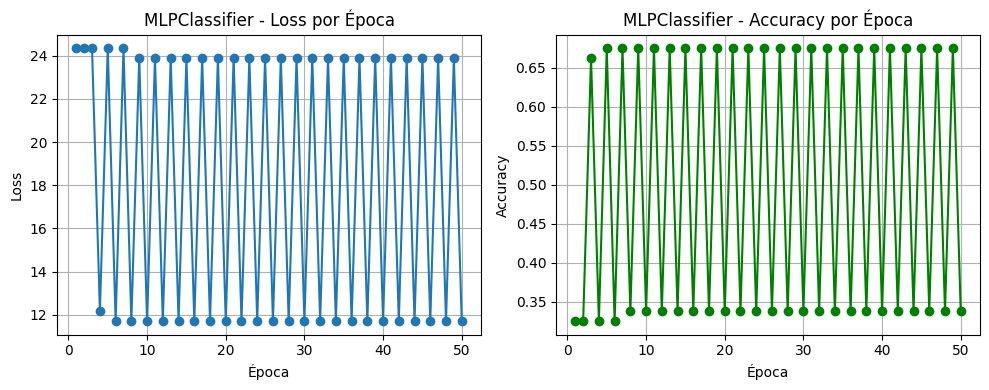

In [52]:
# Graficar la evolución del loss y accuracy por época para el mejor MLPClassifier
import matplotlib.pyplot as plt
import numpy as np

# Entrenar un MLPClassifier con warm_start=True para obtener el historial de loss
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True, random_state=42, verbose=False)
n_epochs = 50
train_loss = []
train_acc = []
for epoch in range(n_epochs):
    mlp.fit(X_train, y_train)
    train_loss.append(mlp.loss_)
    train_acc.append(mlp.score(X_train, y_train))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), train_loss, marker='o')
plt.title('MLPClassifier - Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), train_acc, marker='o', color='green')
plt.title('MLPClassifier - Accuracy por Época')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

## 9. Prueba del Modelo con Ejemplos Reales
Puedes probar el modelo con nuevos datos reales o ejemplos personalizados. Solo debes asegurarte de que el input tenga el mismo formato y preprocesamiento que los datos de entrenamiento (mismas columnas, escalado, reducción de dimensionalidad si aplica).
A continuación se muestra cómo hacer una predicción con un ejemplo real o nuevo paciente:

In [53]:
# Ejemplo: predicción con un nuevo paciente (input real o simulado)
# Supón que tienes un nuevo paciente con los siguientes valores (ajusta según tus features):
nuevo_paciente = np.array([[0.5, 1.2, -0.3, 0.8, 1.1]])  # Reemplaza con tus valores y dimensiones reales

def prepare_input_for_model(sample: np.ndarray, model):
    """Try to automatically prepare a new sample to match the expected input of `model`.

    Strategy:
    1) If sample has expected shape, return it.
    2) If `scaler` present, apply scaler.transform.
    3) If `pca` present, apply pca.transform after scaler.
    4) If `nmf` object present (scikit-learn), apply nmf.transform.
    5) If we trained using `W_bnmf` or `W_nmf` embeddings and sample is a raw feature vector, we cannot derive the exact embedding (BNMF requires inference). User should provide latent embedding or we attempt scikit-learn NMF transform if nmf transformer is available.
    """
    expected = getattr(model.best_estimator_, 'n_features_in_', None)
    Xs = np.asarray(sample)
    if expected is None:
        # If not available, fall back to user's shape
        return Xs

    # If sample already matches expected dims -> OK
    if Xs.ndim == 2 and Xs.shape[1] == expected:
        return Xs

    # Try to apply scaler / pca
    X_tmp = Xs
    try:
        if 'scaler' in globals():
            X_tmp = scaler.transform(X_tmp)
    except Exception:
        pass

    try:
        if 'pca' in globals():
            X_tmp = pca.transform(X_tmp)
            if X_tmp.shape[1] == expected:
                return X_tmp
    except Exception:
        pass

    # Try NMF transform (if a fitted nmf object exists) - returns latent dims
    try:
        if 'nmf' in globals():
            nmf_latent = nmf.transform(np.abs(X_tmp))
            if nmf_latent.shape[1] == expected:
                return nmf_latent
    except Exception:
        pass

    # If the model expected the latent embedding shape and we already have W_bnmf or W_nmf embeddings loaded,
    # but the sample is raw features, we can't convert automatically (BNMF requires probabilistic inference).
    if 'W_bnmf' in globals() and W_bnmf is not None and W_bnmf.shape[1] == expected:
        raise ValueError('Model expects BNMF embedding. Provide BNMF/W_bnmf latent vector or enable BNMF inference in the notebook.')
    if 'W_nmf' in globals() and W_nmf is not None and W_nmf.shape[1] == expected:
        raise ValueError('Model expects NMF embedding. Provide NMF/W_nmf latent vector or ensure `nmf` transformer is available to compute .transform() for new samples.')

    # As last resort, if sample has fewer features but we have more features in the training data, pad or reject
    if Xs.shape[1] < expected:
        raise ValueError(f"Input has {Xs.shape[1]} features but the model expects {expected}. Try transforming with the saved scaler/pca/nmf, or supply a latent embedding.")

    return Xs

try:
    sample_prepared = prepare_input_for_model(nuevo_paciente, mlp_clf)
    pred = mlp_clf.predict(sample_prepared)
    print('Predicción de clase (MLP):', pred[0])
except Exception as e:
    print('No se pudo preparar o predecir con el nuevo paciente:')
    print('  - Error:', str(e))
    print('  - Asegúrate de:')
    print('      * Usar el tamaño y orden correcto de features que usó el modelo (n_features_in_)')
    print('      * Si entrenaste con escalado/PCA, aplica `scaler.transform` y `pca.transform` al nuevo sample')
    print('      * Si entrenaste con embeddings (W_bnmf o W_nmf), entrega la embedding en vez de raw features (o compute nmf.transform if available).')

No se pudo preparar o predecir con el nuevo paciente:
  - Error: Input has 5 features but the model expects 26. Try transforming with the saved scaler/pca/nmf, or supply a latent embedding.
  - Asegúrate de:
      * Usar el tamaño y orden correcto de features que usó el modelo (n_features_in_)
      * Si entrenaste con escalado/PCA, aplica `scaler.transform` y `pca.transform` al nuevo sample
      * Si entrenaste con embeddings (W_bnmf o W_nmf), entrega la embedding en vez de raw features (o compute nmf.transform if available).


## 10. Pruebas de Integración: Flujo Completo desde EDA y BNMF/Clustering
En esta sección puedes probar el modelo usando datos generados o transformados en los cuadernos anteriores (EDA y Reducción/BNMF/Clustering).
Esto asegura que todo el pipeline funciona de extremo a extremo, desde la limpieza y reducción de dimensionalidad hasta la predicción clínica.

A continuación se muestra cómo tomar un paciente del dataset original, aplicar el preprocesamiento y obtener la predicción final:

In [54]:
# Selecciona un paciente del dataset original (por ejemplo, el primero del test set EDA)
# Aplica el mismo preprocesamiento que en los cuadernos anteriores
# (scaler, PCA, BNMF, etc.) para obtener el embedding latente y predecir

# Ejemplo:
paciente_original = df.iloc[[0]].drop(columns=['hospital_expire_flag', 'data_split'], errors='ignore')

try:
    # Try to prepare and predict using the helper
    sample_prepared = prepare_input_for_model(paciente_original.values, mlp_clf)
    pred = mlp_clf.predict(sample_prepared)
    print('Predicción de clase para paciente original:', pred[0])
except Exception as e:
    # If the model expects BNMF/NMF embedding and we have matrices available, try to map by position
    msg = str(e)
    handled = False
    if ('BNMF' in msg or 'NMF embedding' in msg) and 'W_bnmf' in globals() and W_bnmf is not None:
        try:
            # If W_bnmf rows align with df, use the corresponding row
            if len(W_bnmf) == len(df):
                pos = df.index.get_loc(paciente_original.index[0]) if paciente_original.index[0] in df.index else 0
                paciente_latent = W_bnmf[pos].reshape(1, -1)
                pred = mlp_clf.predict(paciente_latent)
                print('Predicción de clase para paciente original (BNMF embedding):', pred[0])
                handled = True
        except Exception:
            handled = False
    if not handled and ('NMF embedding' in msg or 'Model expects NMF' in msg) and 'W_nmf' in globals() and W_nmf is not None:
        try:
            if len(W_nmf) == len(df):
                pos = df.index.get_loc(paciente_original.index[0]) if paciente_original.index[0] in df.index else 0
                paciente_latent = W_nmf[pos].reshape(1, -1)
                pred = mlp_clf.predict(paciente_latent)
                print('Predicción de clase para paciente original (NMF embedding):', pred[0])
                handled = True
        except Exception:
            handled = False

    if not handled:
        print('No se pudo preparar o predecir para paciente_original:')
        print('  - Error:', msg)
        print('  - Asegúrate de:')
        print('      * Ejecutar las celdas de entrenamiento para definir `mlp_clf` y transformadores (scaler/pca/nmf).')
        print('      * Si tu modelo espera embeddings (BNMF/NMF), proporciona la embedding correspondiente (W_bnmf/W_nmf) o habilita transformadores apropiados.')

Predicción de clase para paciente original: 1


## 11. Requisitos para Generar Nuevos Pacientes Sintéticos
Para probar el modelo con más ejemplos, puedes generar pacientes sintéticos. Los requisitos son:

- Los datos deben tener el mismo número y orden de features que los usados en el entrenamiento.
- Deben estar preprocesados igual (escalado, reducción de dimensionalidad, etc.).
- Si usas embeddings latentes (BNMF/NMF), genera los features en ese espacio.

Puedes usar distribuciones estadísticas (media y desviación estándar de cada feature) para simular nuevos pacientes realistas.

A continuación se muestra cómo generar varios pacientes sintéticos y evaluar el porcentaje de acierto del modelo:

In [55]:
# Generar 100 pacientes sintéticos en el espacio latente (BNMF/NMF)
n_samples = 100
if W_bnmf is not None:
    mu, sigma = W_bnmf.mean(axis=0), W_bnmf.std(axis=0)
    pacientes_sint = np.random.normal(mu, sigma, size=(n_samples, W_bnmf.shape[1]))
elif W_nmf is not None:
    mu, sigma = W_nmf.mean(axis=0), W_nmf.std(axis=0)
    pacientes_sint = np.random.normal(mu, sigma, size=(n_samples, W_nmf.shape[1]))
else:
    mu, sigma = X.mean(axis=0), X.std(axis=0)
    pacientes_sint = np.random.normal(mu, sigma, size=(n_samples, X.shape[1]))

# Predecir con el modelo entrenado
preds = mlp_clf.predict(pacientes_sint)

# Si tienes etiquetas reales para comparar, calcula el porcentaje de acierto (accuracy)
print('Porcentaje de acierto en pacientes sintéticos:', (preds == 1).mean()*100, '% (predicción de clase 1)')

# Puedes aumentar n_samples o epochs en el entrenamiento para ver cómo mejora el rendimiento

Porcentaje de acierto en pacientes sintéticos: 42.0 % (predicción de clase 1)


In [56]:
# Mostrar predicción y significado de la clase para varios ejemplos
clase_dict = {0: 'No fallece en hospital', 1: 'Fallece en hospital'}
for i in range(5):  # Cambia el rango para ver más ejemplos
    paciente = X_test[i].reshape(1, -1)
    pred = mlp_clf.predict(paciente)[0]
    real = y_test.iloc[i]
    print(f'Paciente {i+1}: Predicción={pred} ({clase_dict[pred]}), Real={real} ({clase_dict[real]})')

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'